# Тестовое задание Python


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import pyarrow as pa
import pyarrow.feather as feather

from datetime import timedelta
from numba import jit
!pip install numba

### Подгрузить датафрейм

In [ ]:
path = 'data.feather'

In [ ]:
df = pd.read_feather(path)

In [ ]:
df.head()

,exchange_time,BTC-USD-SWAP@OKEX_bid_price_1,BTC-USD-SWAP@OKEX_ask_price_1,BTC-USD-SWAP@OKEX_bid_vol_1,BTC-USD-SWAP@OKEX_ask_vol_1
0,2022-02-07 00:00:00.007000+00:00,42418.3,42418.4,51.0,57.0
1,2022-02-07 00:00:00.028000+00:00,42418.3,42418.4,51.0,152.0
2,2022-02-07 00:00:00.066000+00:00,42418.3,42418.4,51.0,83.0
3,2022-02-07 00:00:00.146000+00:00,42418.3,42418.4,51.0,306.0
4,2022-02-07 00:00:00.156000+00:00,42418.3,42418.4,51.0,312.0


### Провести базовый EDA

посчитать среднее, медиану, стандартное отклонение, квартили для столбцов цен (*_price_1) и объёмов (*_vol_1) - отдельно для каждого столбца. Визуализировать боксплотами. Установить, были ли выбросы по ценам (например, через межквартильный размах).

In [ ]:
df.describe()

,BTC-USD-SWAP@OKEX_bid_price_1,BTC-USD-SWAP@OKEX_ask_price_1,BTC-USD-SWAP@OKEX_bid_vol_1,BTC-USD-SWAP@OKEX_ask_vol_1
count,1.534318e+07,1.534318e+07,1.534318e+07,1.534318e+07
mean,4.338289e+04,4.338327e+04,5.955515e+02,5.288940e+02
std,8.976420e+02,8.976375e+02,1.674130e+03,1.194477e+03
min,4.165650e+04,4.165660e+04,1.000000e+00,1.000000e+00
25%,4.250700e+04,4.250730e+04,4.100000e+01,2.500000e+01
50%,4.346060e+04,4.346110e+04,2.160000e+02,1.670000e+02
75%,4.407170e+04,4.407190e+04,7.000000e+02,5.780000e+02
max,4.588670e+04,4.594920e+04,2.999870e+05,2.963020e+05


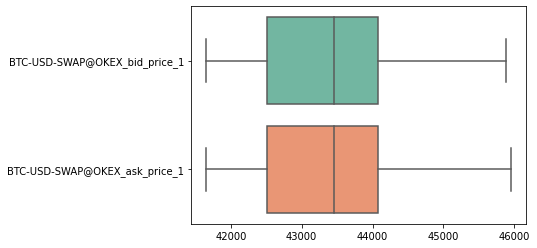

In [ ]:
sns.boxplot(data=df.iloc[:,1:3], orient="h", palette="Set2");

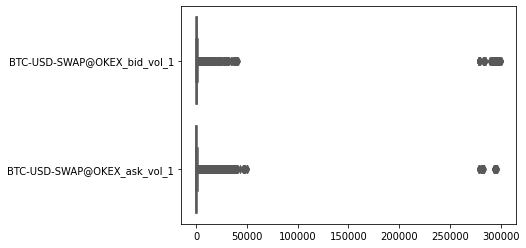

In [ ]:
sns.boxplot(data=df.iloc[:,3:5], orient="h", palette="Set2");

### Визуализировать распределения цен и объёмов любым способом.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


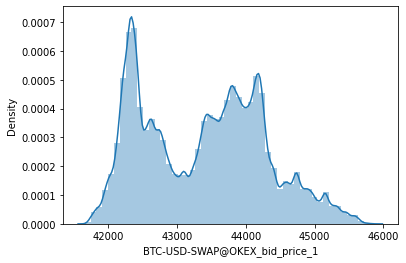

In [ ]:
sns.distplot(df.iloc[:, 1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


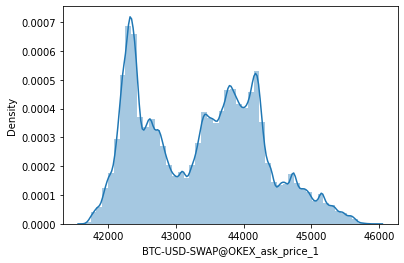

In [ ]:
sns.distplot(df.iloc[:, 2])

### Рассчитать среднюю цену инструмента

 (bid_price+ask_price)/2 для всех точек и по ней рассчитать за для всех точек взвешенную по времени экспоненциальную скользящую среднюю по нижеописанному принципу. Замерить время выполнения (можно просто через %%timeit), попробовать достичь времени выполнения менее 1 с.
Инициализируемся средней ценой для первой строки датафрейма
Если разница по времени со следующей строчкой превышает 1 секунду, то условно считаем её равной одной секунде (параметр ti в формуле ниже)
Очередное значение EMA = прошлое значение EMA + (очередная средняя цена - прошлое значение EMA)*(разница по времени до предыдущего значения)/(10000 секунд):
EMAi=EMAi-1 + (MidPricei - EMAi-1)ti10000 секунд


In [ ]:
@jit(nopython=True)       #использую numba для ускорения расчета
def func(ema, avg_price, deltas):
  for k in range(1, len(ema)):
    ema[k] = ema[k-1] + (avg_price[k] - ema[k-1]) * deltas[k] / 10000
  return ema

In [ ]:
%%timeit
#тест
# avg_price = ((df.iloc[:, 1] + df.iloc[:, 2]) * 0.5).values
# deltas = (df['exchange_time'].shift(-1) - df['exchange_time'])
# deltas[deltas > timedelta(seconds=1)] = timedelta(seconds=1)
# deltas = deltas.dt.microseconds.values * 0.001
# ema = np.zeros(avg_price.shape)
# ema[0] = avg_price[0]
# new_ema = func(ema, avg_price, deltas)
# df['ema'] = new_ema

1 loop, best of 5: 821 ms per loop


In [ ]:
avg_price = ((df.iloc[:, 1] + df.iloc[:, 2]) * 0.5).values
deltas = (df['exchange_time'].shift(-1) - df['exchange_time'])
deltas[deltas > timedelta(seconds=1)] = timedelta(seconds=1)
deltas = deltas.dt.microseconds.values * 0.001
ema = np.zeros(avg_price.shape)
ema[0] = avg_price[0]
new_ema = func(ema, avg_price, deltas)
df['ema'] = new_ema

In [ ]:
df.head()

,exchange_time,BTC-USD-SWAP@OKEX_bid_price_1,BTC-USD-SWAP@OKEX_ask_price_1,BTC-USD-SWAP@OKEX_bid_vol_1,BTC-USD-SWAP@OKEX_ask_vol_1,ema,position
0,2022-02-07 00:00:00.007000+00:00,42418.3,42418.4,51.0,57.0,42418.35,0
1,2022-02-07 00:00:00.028000+00:00,42418.3,42418.4,51.0,152.0,42418.35,0
2,2022-02-07 00:00:00.066000+00:00,42418.3,42418.4,51.0,83.0,42418.35,0
3,2022-02-07 00:00:00.146000+00:00,42418.3,42418.4,51.0,306.0,42418.35,0
4,2022-02-07 00:00:00.156000+00:00,42418.3,42418.4,51.0,312.0,42418.35,0


In [ ]:
df['ema'].max(), df['ema'].min()

(45785.80397319924, 41686.07804571633)

In [ ]:
df['ema'].isna().value_counts()

False    15343184
True            1
Name: ema, dtype: int64

In [ ]:
df['ema'].max()

45785.80397319924

### Ввести столбец position, инициализировать нулями


In [ ]:
df['position'] = 0

In [ ]:
df.head()

,exchange_time,BTC-USD-SWAP@OKEX_bid_price_1,BTC-USD-SWAP@OKEX_ask_price_1,BTC-USD-SWAP@OKEX_bid_vol_1,BTC-USD-SWAP@OKEX_ask_vol_1,ema,position
0,2022-02-07 00:00:00.007000+00:00,42418.3,42418.4,51.0,57.0,42418.35,0
1,2022-02-07 00:00:00.028000+00:00,42418.3,42418.4,51.0,152.0,42418.35,0
2,2022-02-07 00:00:00.066000+00:00,42418.3,42418.4,51.0,83.0,42418.35,0
3,2022-02-07 00:00:00.146000+00:00,42418.3,42418.4,51.0,306.0,42418.35,0
4,2022-02-07 00:00:00.156000+00:00,42418.3,42418.4,51.0,312.0,42418.35,0


### Рассчитать значения в этом столбце по следующей логике:

первые 10000 секунд - 0
далее, если средняя цена в очередной строке больше EMA более чем на 50 и значение в предыдущей строке pos меньше 10 -> +1
Если текущая средняя цена < EMA более чем на 50 и предыдущее значение pos > -10 -> -1
Иначе значение не меняется
Постараться уложиться в 20 секунд.


In [ ]:
@jit(nopython=True)
def get_position(avg_price, ema, first_seconds = 10000):
  seconds_count = 0
  idx = 0
  for i, k in enumerate(deltas):
    seconds_count += k
    if seconds_count > first_seconds:
      idx = i
      break
  position = np.zeros(ema.shape)
  for i in range(idx, len(position)):
    if ((avg_price[i] - new_ema[i]) > 50) and position[i-1] < 10:
      position[i]+=1
    elif ((new_ema[i] - avg_price[i]) > 50) and position[i-1] > -10:
      position[i]-=1
    else:
      position[i] = position[i-1]
  return position

In [ ]:
%%timeit
#тест
df['position'] = get_position(avg_price, ema)

1 loop, best of 5: 133 ms per loop


In [ ]:
df.head()

,exchange_time,BTC-USD-SWAP@OKEX_bid_price_1,BTC-USD-SWAP@OKEX_ask_price_1,BTC-USD-SWAP@OKEX_bid_vol_1,BTC-USD-SWAP@OKEX_ask_vol_1,ema,position
0,2022-02-07 00:00:00.007000+00:00,42418.3,42418.4,51.0,57.0,42418.35,0.0
1,2022-02-07 00:00:00.028000+00:00,42418.3,42418.4,51.0,152.0,42418.35,0.0
2,2022-02-07 00:00:00.066000+00:00,42418.3,42418.4,51.0,83.0,42418.35,0.0
3,2022-02-07 00:00:00.146000+00:00,42418.3,42418.4,51.0,306.0,42418.35,0.0
4,2022-02-07 00:00:00.156000+00:00,42418.3,42418.4,51.0,312.0,42418.35,0.0


### Визуализировать результаты.

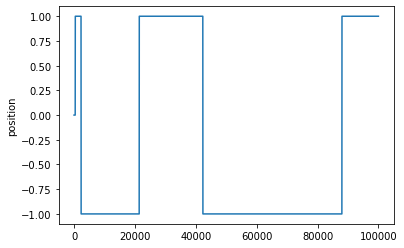

In [ ]:
y = df['position'][:100000]
sns.lineplot(x=range(len(y)), y=y)

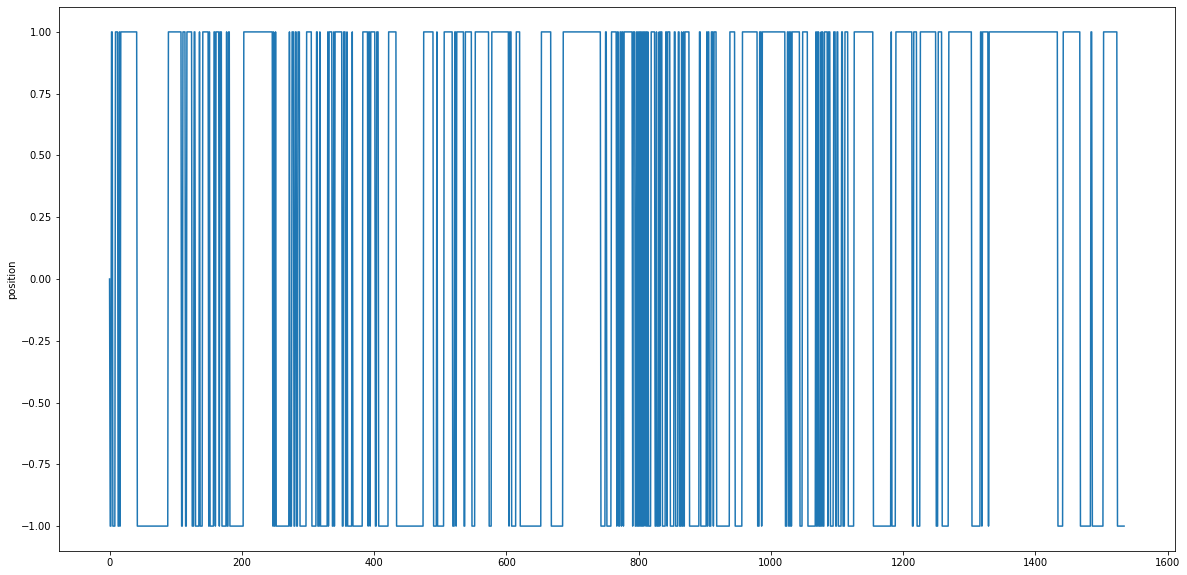

In [ ]:
y = df['position'][::10000]
plt.figure(figsize=(20,10))
sns.lineplot(x=range(len(y)), y=y)
plt.show()

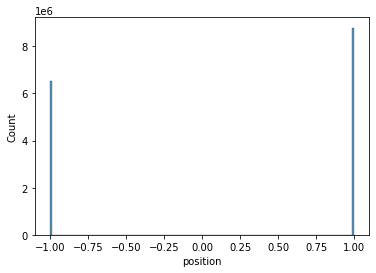

In [ ]:
sns.histplot(df['position'])

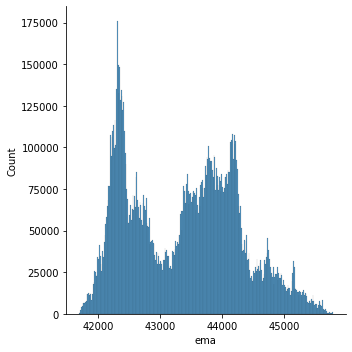

In [ ]:
sns.displot(df['ema'])

# Тестовое задание SQL

Предоставленная база SQLITE содержит 2 таблицы - данные по депозитам на условных торговых счетах и таблицу соответствия счетов торговым роботам, с периодами активности этих роботов.
В таблице депозитов есть поле timestamp - кратное минуте, записи в рамках одной минуты для разных счетов имеют одинаковый timestamp.
У каждого робота 2 счёта, и они могут меняться (в этом случае период активности по счёту завершается, и в таблице открывается новый период с новым счётом).

Необходимо написать SQL запросы:


In [ ]:
from sqlite3 import connect
import pandas as pd
conn = connect(database='test.sqlite')

In [ ]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type = 'table'", conn)

,name
0,inv
1,deposits


In [ ]:
pd.read_sql("SELECT * FROM inv GROUP BY field2", conn)

,field1,field2,field3,field4
0,bot2,a.acc1,2021-04-25 12:01:00+03,2022-01-12 12:00:00+03
1,bot1,a.acc2,2021-04-25 12:01:00+03,2022-01-12 12:00:00+03
2,bot3,a.acc3,2021-04-25 12:01:00+03,2022-01-12 12:00:00+03
3,bot4,a.acc4,2021-04-25 12:01:00+03,2022-01-12 12:00:00+03
4,bot1,b.acc1,2021-04-25 12:01:00+03,2022-01-12 12:00:00+03
5,bot3,b.acc2,2021-04-25 12:01:00+03,2022-01-12 12:00:00+03
6,bot2,b.acc3,2021-04-25 12:01:00+03,2022-01-12 12:00:00+03
7,bot4,b.acc4,2021-04-25 12:01:00+03,2022-01-12 12:00:00+03


In [ ]:
pd.read_sql("SELECT * FROM deposits LIMIT 10", conn)

,timestamp,account_id,deposit
0,2022-02-11 15:48:00+03,a.acc2,7.586713
1,2022-02-11 15:48:00+03,a.acc3,8.357887
2,2022-02-11 15:48:00+03,a.acc1,3.370693
3,2022-02-11 15:48:00+03,a.acc4,4.969985
4,2022-02-11 15:48:00+03,b.acc4,6.128907
5,2022-02-11 15:48:00+03,b.acc1,8.057461
6,2022-02-11 15:48:00+03,b.acc2,3.455221
7,2022-02-11 15:48:00+03,b.acc3,2.581823
8,2022-02-11 15:49:00+03,b.acc1,8.054418
9,2022-02-11 15:49:00+03,b.acc2,3.445522


### Вывести сумму депозитов по счетам для каждого робота за его периоды активности.


**ВОПРОС:** Не совсем понял вопрос... Просуммировать все значения за весь период активности по полю deposit для каждого \
робота по счетам или посчитать сумму остатков на счетах на момент выключения робота? Ниже сделал по первому варианту, составив сводную таблицу...

In [ ]:
query = "SELECT field1 AS bot_name, \
        field2 AS acc_id, \
        SUM(deposit) as sum_deposits\
        FROM inv INNER JOIN deposits ON account_id == field2 \
        WHERE timestamp BETWEEN  field3 AND field4 \
        GROUP BY field1, field2 \
        LIMIT 20"   #тут можно еще раз просуммировать с помощью over...
pd.read_sql(query, conn)

,bot_name,acc_id,sum_deposits
0,bot1,a.acc1,5603.407453
1,bot1,b.acc1,34182.278011
2,bot2,a.acc2,12790.299638
3,bot2,b.acc2,14687.001508
4,bot3,a.acc3,14088.706722
5,bot3,b.acc3,10960.289956
6,bot4,a.acc4,8270.597224
7,bot4,b.acc4,26223.460494


### Рассчитать для каждого робота доход или убыток (в валюте) с начала записанных в таблице депозитов данных до каждого timestamp’a


In [ ]:
#использовал объединение двух таблиц. в первой таблице получил время начала торгов и счет на тот момент для каждого аккаунта.
#вторая таблица сводная по ботам и аккаунтам. после объединения сделал еще раз селект для рассчета разницы.
query = "SELECT timestamp, deposit_on_time - deposit AS deposit_diff FROM (SELECT deposit as deposit_on_time, field1, \
        field2, field3, field4,timestamp, MIN(timestamp) as start_time \
         FROM inv JOIN deposits ON inv.field2 = deposits.account_id \
         WHERE timestamp BETWEEN field3 AND field4 \
         GROUP BY field1, field2) AS t1 JOIN (SELECT i.field1 AS bot_name, \
        i.field2 AS acc_id, i.field3 AS time_open, i.field4 AS time_close, d.deposit \
        FROM inv i JOIN deposits d ON i.field2 = d.account_id \
        WHERE timestamp BETWEEN time_open AND time_close) AS t2 ON t1.field2 = t2.acc_id"
pd.read_sql(query, conn)

,timestamp,deposit_diff
0,2022-02-11 15:48:00+03,0.000000
1,2022-02-11 15:48:00+03,-0.003160
2,2022-02-11 15:48:00+03,-0.007713
3,2022-02-11 15:48:00+03,-0.010551
4,2022-02-11 15:48:00+03,-0.008427
...,...,...
23541,2022-02-11 15:48:00+03,-0.141643
23542,2022-02-11 15:48:00+03,-0.142120
23543,2022-02-11 15:48:00+03,-0.140367
23544,2022-02-11 15:48:00+03,-0.143242


### Для каждого робота вывести таблицу, в которой отражались бы в разных столбцах депозиты по его счетам (для всех таймстемпов), а также столбец с относительной разницей депозитов (т.е. |депозит1-депозит2|/(депозит1 + депозит2)) и флаг, если такая разница больше 10%.


### **ОТВЕТ ПРИЛОЖУ СКРИНАМИ ИЗ DATAGRIP** так как в колабе возникают проблемы с использованием оконных фунций(


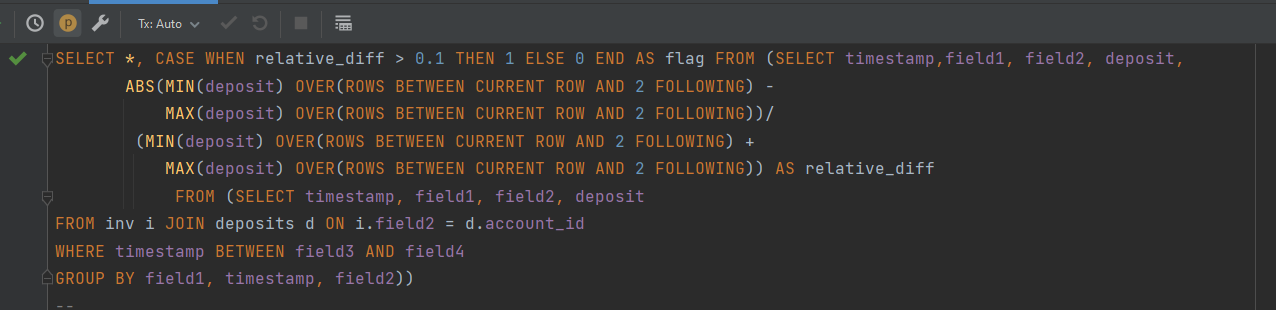

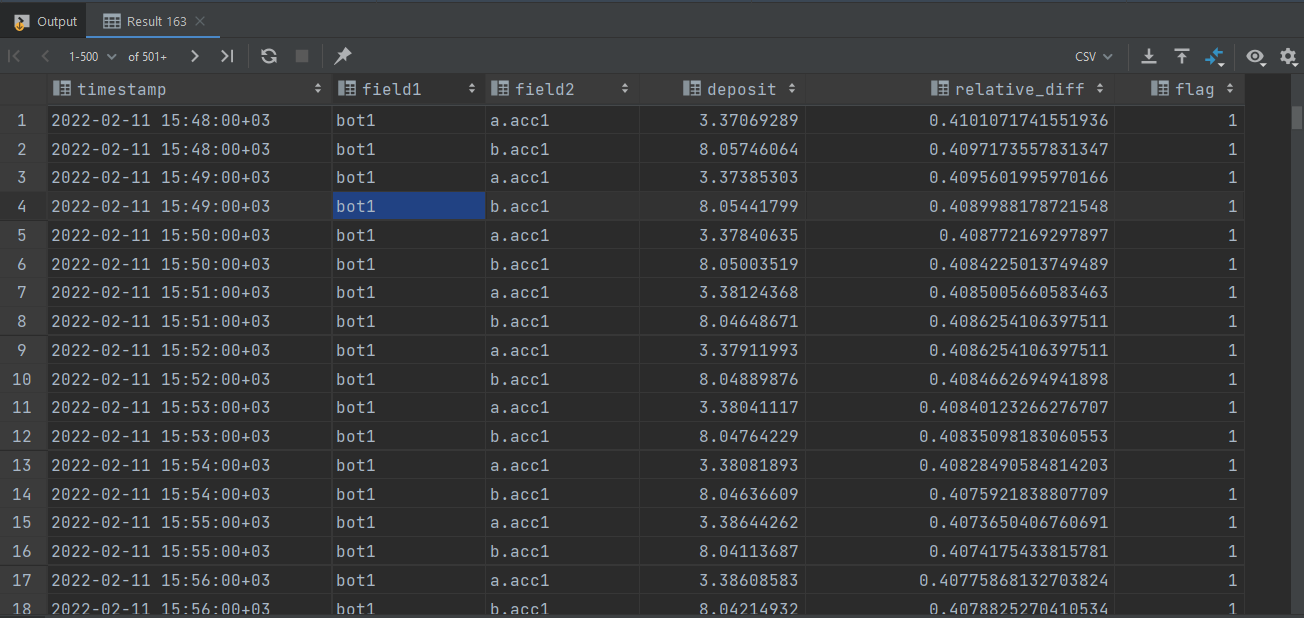

### Для каждого таймстемпа вывести название робота, на котором больше всего денег.


In [ ]:
query = "SELECT field1, field2, timestamp, MAX(deposit) FROM inv i JOIN deposits d ON i.field2 = d.account_id GROUP BY timestamp"
pd.read_sql(query, conn)

,field1,field2,timestamp,MAX(deposit)
0,bot3,a.acc3,2022-02-11 15:48:00+03,8.357887
1,bot3,a.acc3,2022-02-11 15:49:00+03,8.360569
2,bot3,a.acc3,2022-02-11 15:50:00+03,8.364434
3,bot3,a.acc3,2022-02-11 15:51:00+03,8.366842
4,bot3,a.acc3,2022-02-11 15:52:00+03,8.365039
...,...,...,...,...
4200,bot3,a.acc3,2022-02-14 14:14:00+03,8.309206
4201,bot3,a.acc3,2022-02-14 14:15:00+03,8.308889
4202,bot3,a.acc3,2022-02-14 14:16:00+03,8.309868
4203,bot3,a.acc3,2022-02-14 14:17:00+03,8.308457


In [ ]:
#если имелось ввиду что на каждый таймстемп вывести одного и того же бота у которого больше всего денег
query = "SELECT timestamp, field1 FROM ( \
        SELECT timestamp, account_id, MAX(sum_d) FROM \
        (SELECT timestamp, account_id, SUM(deposit) as sum_d FROM deposits \
        GROUP BY timestamp, account_id) \
        GROUP by timestamp) tmp INNER JOIN inv \
        ON inv.field2 = tmp.account_id AND tmp.timestamp BETWEEN inv.field3 AND inv.field4 \
        ORDER by timestamp;"
pd.read_sql(query, conn)

,timestamp,field1
0,2022-02-11 15:48:00+03,bot3
1,2022-02-11 15:49:00+03,bot3
2,2022-02-11 15:50:00+03,bot3
3,2022-02-11 15:51:00+03,bot3
4,2022-02-11 15:52:00+03,bot3
...,...,...
4200,2022-02-14 14:14:00+03,bot3
4201,2022-02-14 14:15:00+03,bot3
4202,2022-02-14 14:16:00+03,bot3
4203,2022-02-14 14:17:00+03,bot3
